In [1]:
!date

Thu Dec 23 08:53:34 PST 2021


# Check for expression of Alex' potential markers in separately clustered CTRL data
#### Unfiltered data obtained from using kb with multimapping function. Ref genome includes WRE.

___

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext blackcellmagic

In [3]:
import sys
import anndata
import scvi

import scanpy as sc
import numpy as np
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import pandas as pd

sc.set_figure_params(figsize=(6, 6), frameon=False)
sc.settings.n_jobs=2

In [4]:
# set random seed
np.random.seed(926)

In [5]:
def nd(arr):
    """
    Funciton to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

___

# Load clustered and celltype assigned ctrl/experiment data

In [14]:
adata = anndata.read('../../finchseq_data/ctrl_celltype.h5ad')

# Mark celltype and connectivity with "c" for control
adata.obs["batch_g"] = "control"
adata.obs["celltype_sep"] = adata_ctrl.obs["celltype"].astype(str) + "_c"
adata.obs["connectivity_sep"] = adata_ctrl.obs["connectivity"].astype(str) + "_c"
adata.obs

,species,batch,n_counts_processed,batch_index,n_counts_raw,leiden,celltype,connectivity,batch_g,celltype_sep,connectivity_sep
barcode,,,,,,,,,,,
AAACCCAAGCACTGGA-0,zebrafinch,control1,483.000000,0,483.000000,15,mural cells 1,0,control,mural cells 1_c,0_c
AAACCCAAGCGTCAAG-0,zebrafinch,control1,946.000061,0,946.000061,12,microglia 1,1,control,microglia 1_c,1_c
AAACCCAAGGTCACAG-0,zebrafinch,control1,1068.000000,0,1068.000000,1,GABAergic neurons 1,2,control,GABAergic neurons 1_c,2_c
AAACCCAAGTCATTGC-0,zebrafinch,control1,1407.000000,0,1407.000000,9,astrocytes 2,3,control,astrocytes 2_c,3_c
AAACCCAAGTGCTACT-0,zebrafinch,control1,1060.000000,0,1060.000000,11,GABAergic neurons 2,4,control,GABAergic neurons 2_c,4_c
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAAATAAGC-1,zebrafinch,control2,663.000000,1,663.000000,0,glutamatergic neurons 1,undefined 1,control,glutamatergic neurons 1_c,undefined 1_c
TTTGTTGCAGTTGTCA-1,zebrafinch,control2,1120.000000,1,1120.000000,9,astrocytes 2,3,control,astrocytes 2_c,3_c
TTTGTTGCATCGATAC-1,zebrafinch,control2,1177.000000,1,1177.000000,9,astrocytes 2,3,control,astrocytes 2_c,3_c


___

# Load marker list and find markers in genome

In [28]:
markers = pd.read_csv('markers_Alex.txt', header = None)
markers.head()

,0
0,ENPP1
1,ENSTGUG00000013568
2,CENPW
3,ENSTGUG00000028413
4,KLHL14


Find gene ID for each gene:

In [29]:
markers["gene_name_id"] = np.arange(len(markers[0].values))

In [30]:
# index counter
i = 0

for gene in markers[0].values:
    gene_name_id = []
    
    if gene.startswith("ENS"):
        gni = adata.var.iloc[np.where(adata.var.index.str.contains(gene))]
    
    else:
        gni = adata.var.iloc[np.where(adata.var.index.str.startswith(gene))]

    if len(gni) > 0:
        gene_name_id = gni.index[0]
    else:
        gene_name_id = np.nan

    markers["gene_name_id"][i] = gene_name_id
    i += 1

/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Notes:  
MRVI1 found as IRAG1 ENSTGUG00000007955 on Ensembl  
CMYA5 matched to "novel gene" ENSTGUG00000028894 on Ensembl  

In [31]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
markers

,0,gene_name_id
0,ENPP1,ENPP1_ENSTGUG00000011628.2
1,ENSTGUG00000013568,_ENSTGUG00000013568.2
2,CENPW,CENPW_ENSTGUG00000027690.1
3,ENSTGUG00000028413,_ENSTGUG00000028413.1
4,KLHL14,KLHL14_ENSTGUG00000010774.2
5,ENSTGUG00000015726,_ENSTGUG00000015726.2
6,ENSTGUG00000027036,_ENSTGUG00000027036.1
7,ENSTGUG00000028768,_ENSTGUG00000028768.1
8,TMPRSS7,TMPRSS7_ENSTGUG00000013593.2
9,ENSTGUG00000019134,_ENSTGUG00000019134.1


____

# Plot expression of potential markers in glut neurons

In [44]:
all_markers = np.concatenate((["SLC17A6_ENSTGUG00000004570.2", "SCN3B_ENSTGUG00000000607.2"], markers["gene_name_id"].values))

/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'batch_g' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'celltype_sep' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'connectivity_sep' as categorical


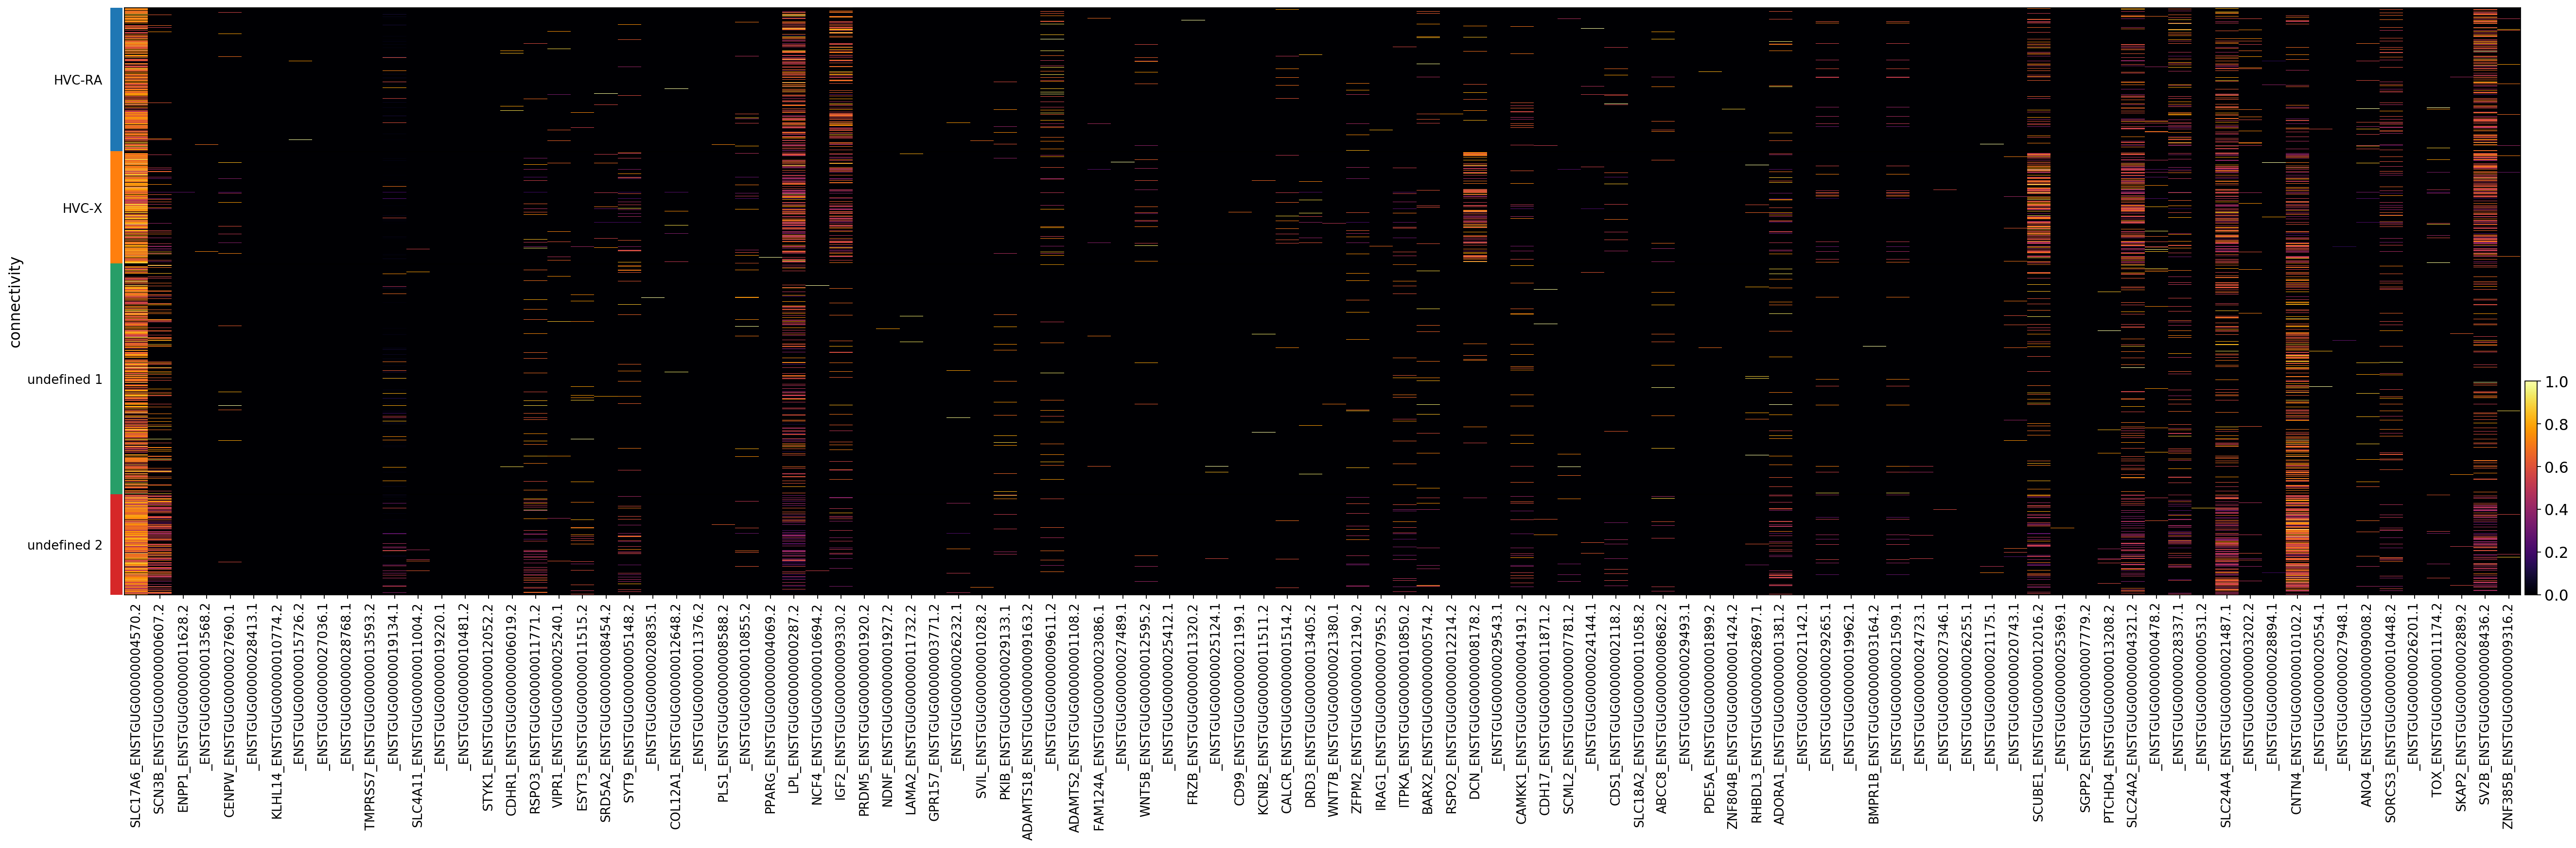

In [45]:
sc.pl.heatmap(
    adata[np.char.startswith(nd(adata.obs.celltype.values).astype(str), "glutamatergic neurons")],
    all_markers,
    groupby="connectivity",
#     dendrogram=True, # This messes up the ordering of the celltypes
    show_gene_labels=True,
#     var_group_positions=var_groups,
#     var_group_labels=var_labels,
#     var_group_rotation=90,
    use_raw=False, # By default adata.raw.X is plotted. If use_raw=False is set, then adata.X is plotted. 
    cmap="inferno", # Alternative cmap: magma
    standard_scale="var", # standardize that dimension between 0 and 1, meaning for each variable or observation, subtract the minimum and divide each by its maximum
    swap_axes=False,
    figsize=(40, 10),
    save=True
)

/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'batch_g' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'celltype_sep' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'connectivity_sep' as categorical


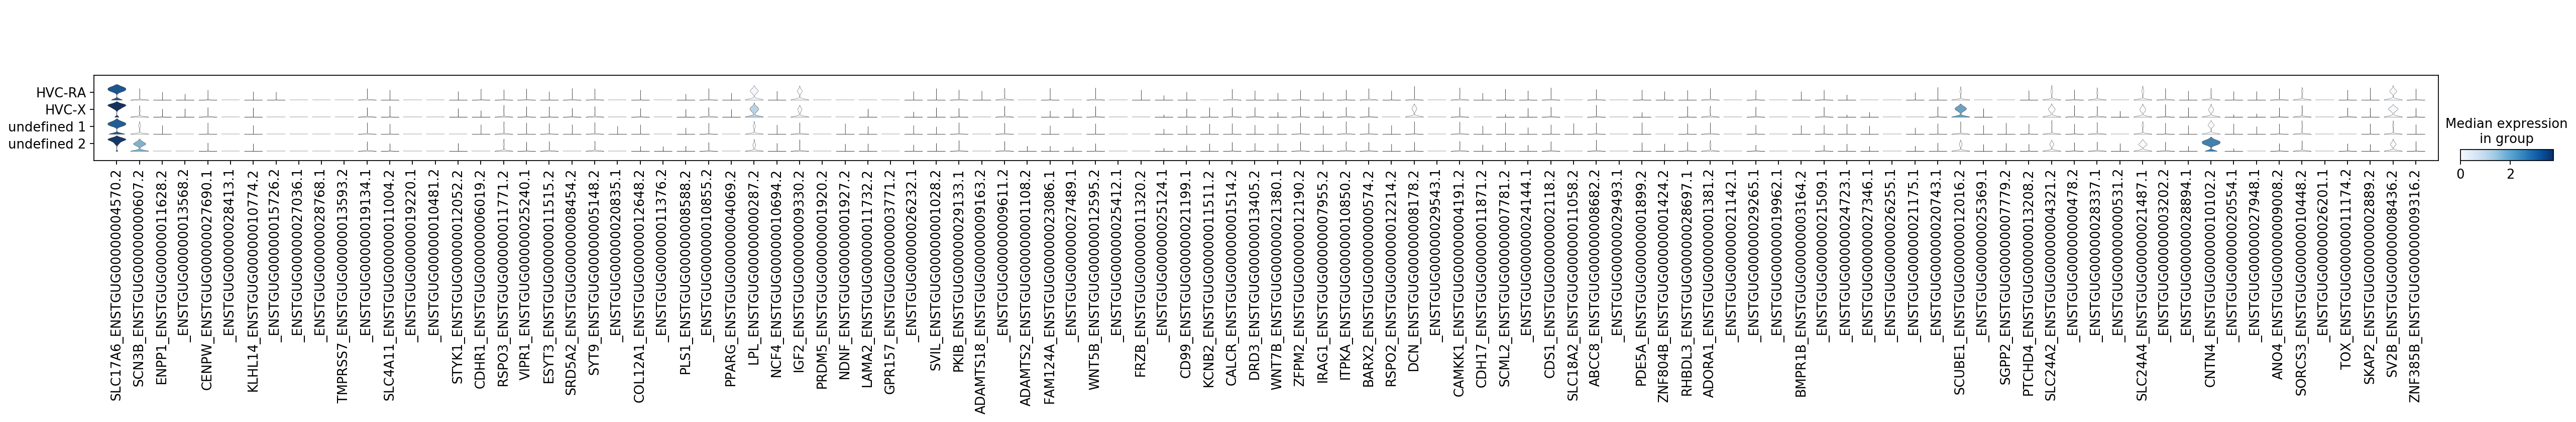

In [46]:
sc.pl.stacked_violin(adata[np.char.startswith(nd(adata.obs.celltype.values).astype(str), "glutamatergic neurons")], 
                     all_markers, 
                     groupby='connectivity', 
#                      title="Marker gene expression in connectivity clusters", 
                     rotation=90, 
                     sharey=True,
                     use_raw=False,
                     swap_axes=False,
                     save=True
#                      vmin=0,
#                      vmax=0.75
                    )

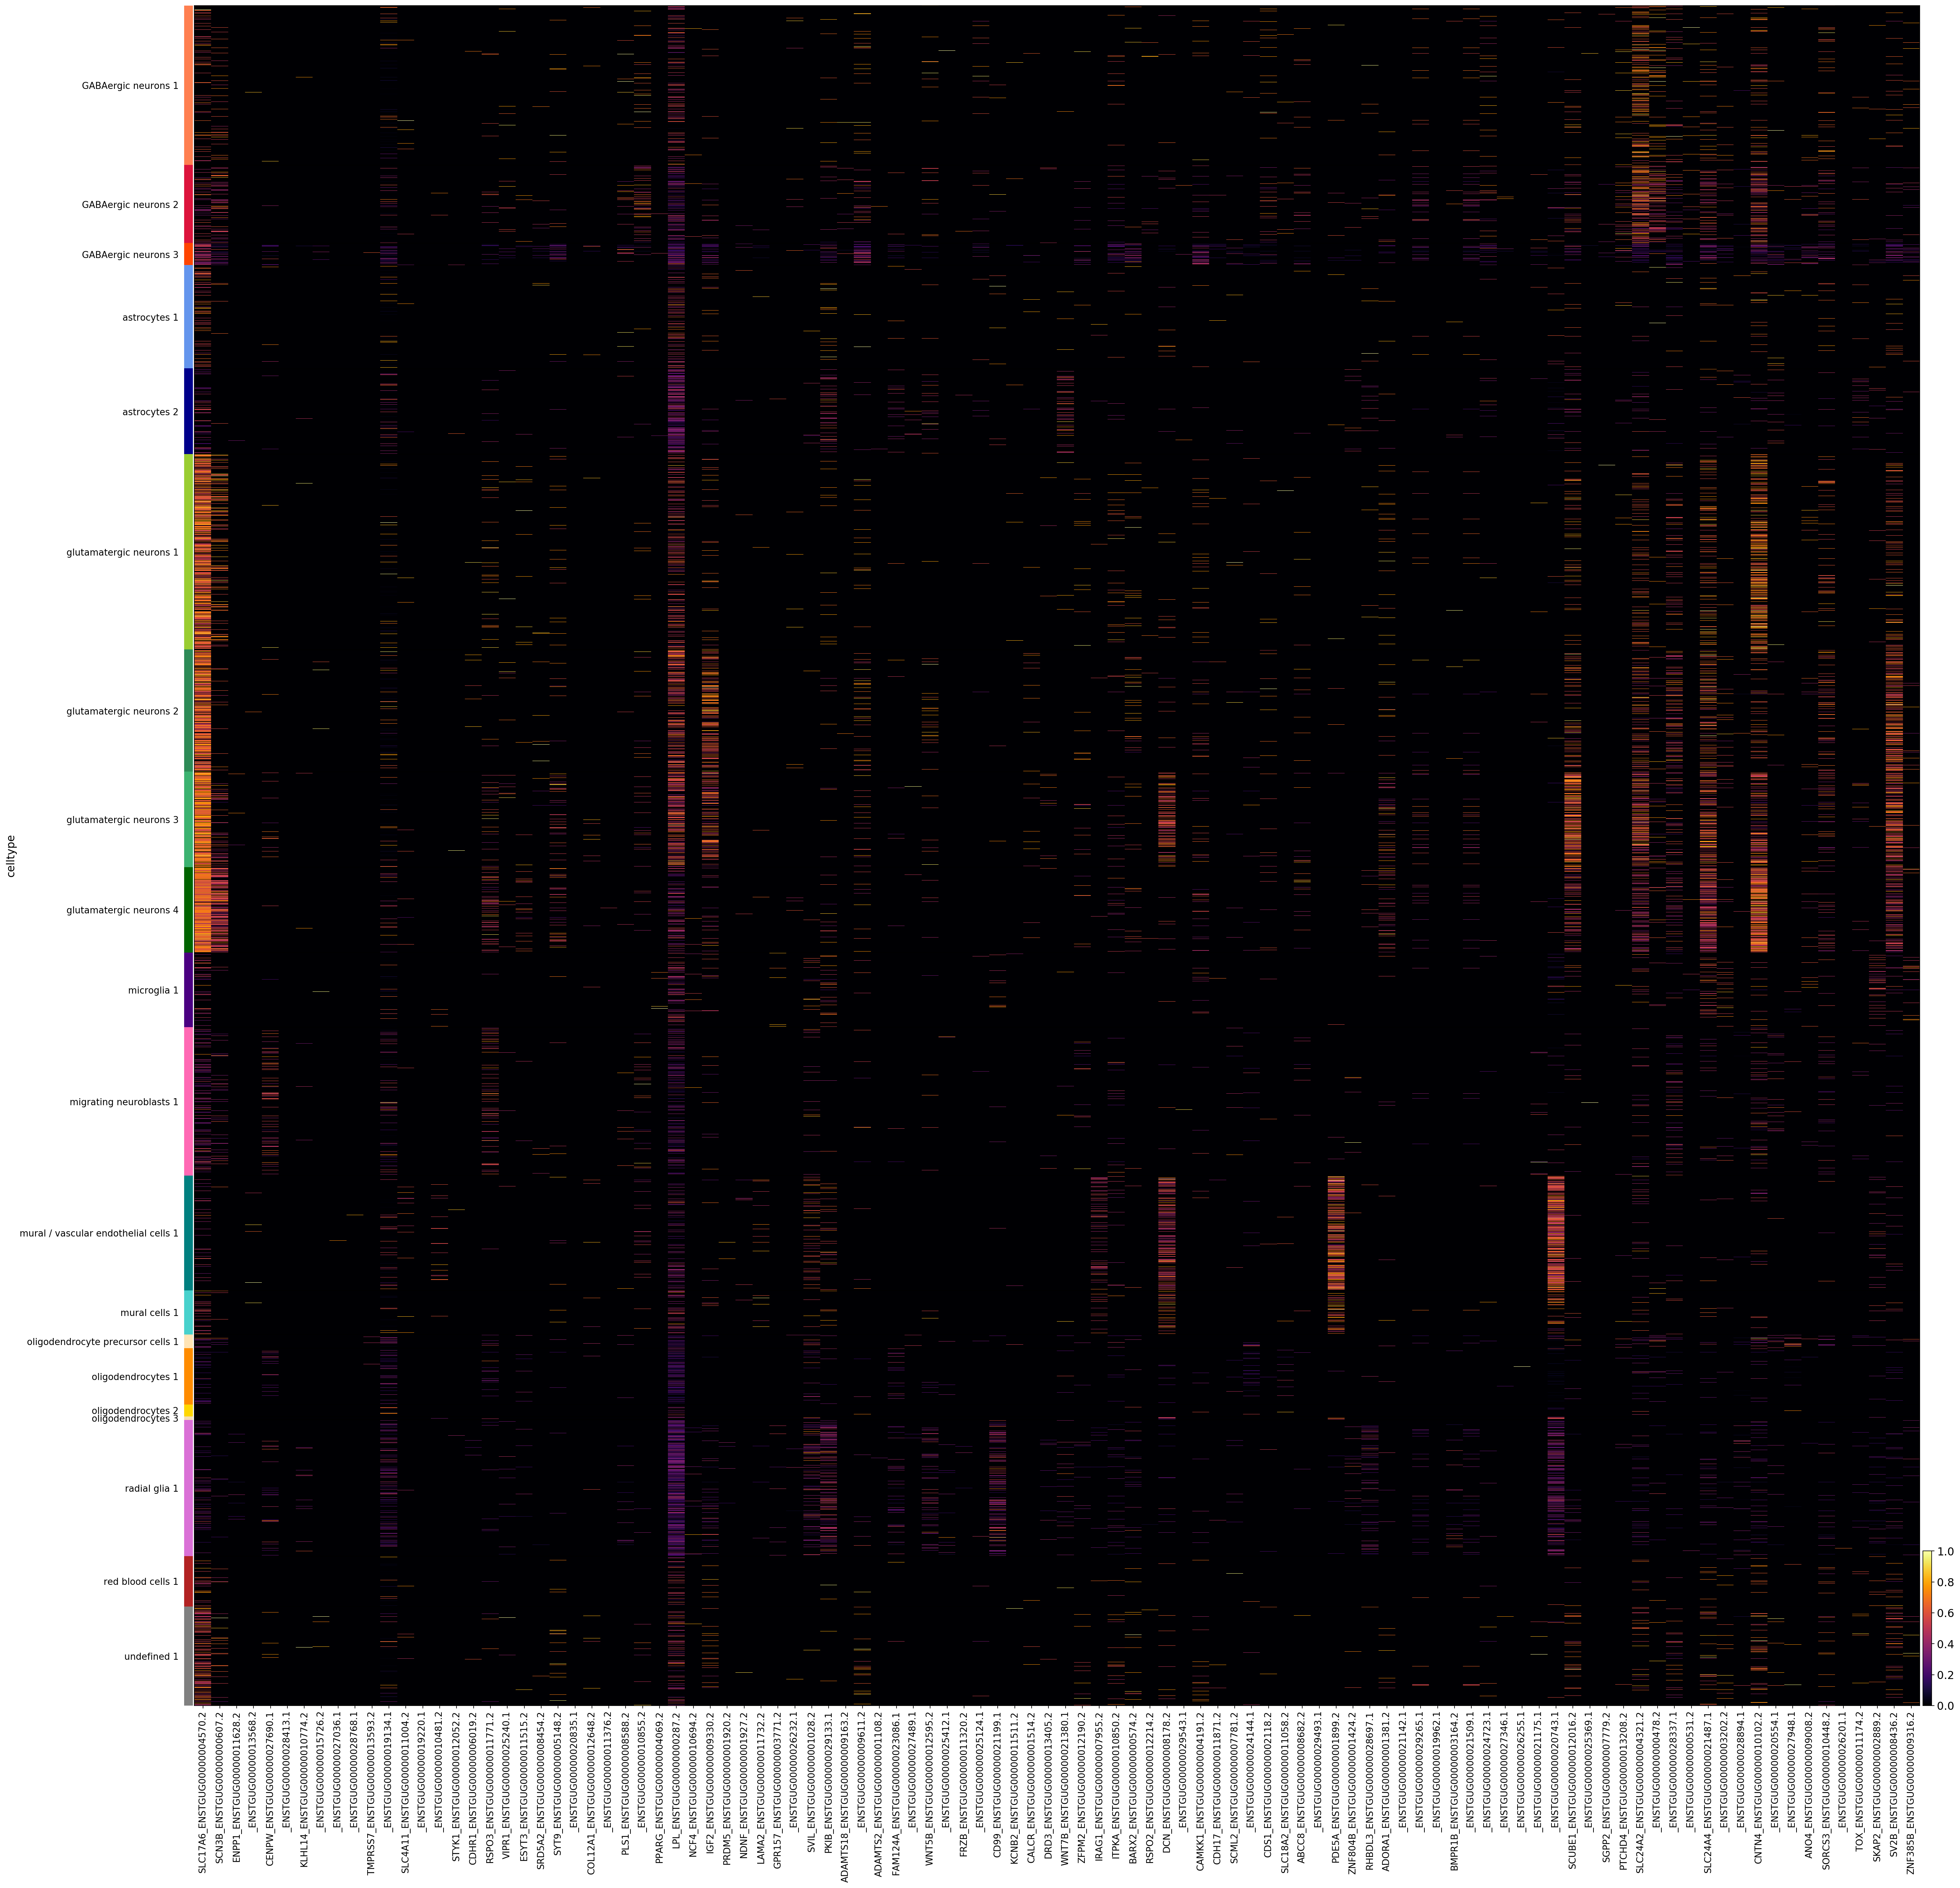

In [48]:
sc.pl.heatmap(
    adata,
    all_markers,
    groupby="celltype",
#     dendrogram=True, # This messes up the ordering of the celltypes
    show_gene_labels=True,
#     var_group_positions=var_groups,
#     var_group_labels=var_labels,
#     var_group_rotation=90,
    use_raw=False, # By default adata.raw.X is plotted. If use_raw=False is set, then adata.X is plotted. 
    cmap="inferno", # Alternative cmap: magma
    standard_scale="var", # standardize that dimension between 0 and 1, meaning for each variable or observation, subtract the minimum and divide each by its maximum
    swap_axes=False,
    figsize=(40, 40),
    save=True
)